# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.utils import shuffle


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec             

# EDA

In [86]:
df = pd.read_csv('/Users/iris/Documents/projects/fletcher/Reviews.csv')

In [87]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [89]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [90]:
df.isnull().values.any()

True

In [91]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [92]:
df_working = df.dropna()

In [93]:
df_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568411 non-null int64
ProductId                 568411 non-null object
UserId                    568411 non-null object
ProfileName               568411 non-null object
HelpfulnessNumerator      568411 non-null int64
HelpfulnessDenominator    568411 non-null int64
Score                     568411 non-null int64
Time                      568411 non-null int64
Summary                   568411 non-null object
Text                      568411 non-null object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


Interestingly, most reviews are positive (mean is 4.18)

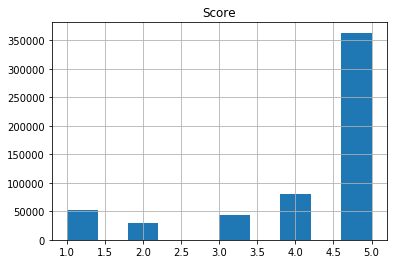

In [94]:
df_working.hist(column = 'Score');

In [95]:
## Check out out how many of each score there is
score_counts = df_working.Score.value_counts().to_dict()
score_counts

{5: 363111, 4: 80655, 1: 52264, 3: 42638, 2: 29743}

In [96]:
## What review was the most helpful one?
df_working.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568411.000000,568411.000000,568411.000000,568411.000000,5.684110e+05
mean,284227.440964,1.743874,2.227876,4.183309,1.296261e+09
std,164099.020907,7.636781,8.288752,1.310368,4.803792e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142114.500000,0.000000,0.000000,4.000000,1.271290e+09
50%,284224.000000,0.000000,1.000000,5.000000,1.311120e+09
75%,426341.500000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09


In [97]:
## Log scale HelpfulnessNumerator to respond to skewness
p = 0.0000001
df_working['HelpfulnessNumerator'].apply(lambda x: np.log(p + x))
df_working.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


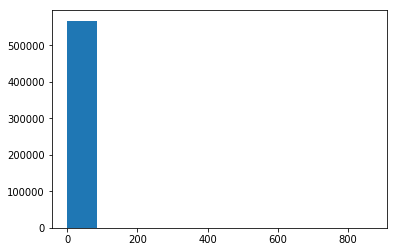

In [98]:
plt.hist(df['HelpfulnessNumerator']);

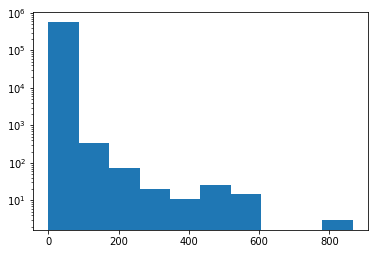

In [99]:
plt.hist(df['HelpfulnessNumerator'], log=True);

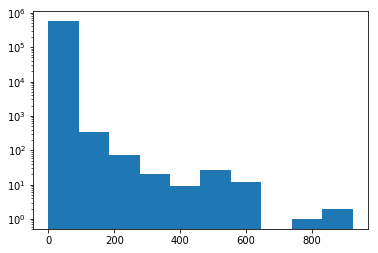

In [100]:
plt.hist(df_working.HelpfulnessDenominator, log = True);

In [101]:
## There are review that have been considered very helpful. Explore them further.

super_help = pd.Series(range(600,1000))

In [102]:
df_working.loc[df_working['HelpfulnessNumerator'].isin(super_help)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
190733,190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,866,878,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />*******...
207712,207713,B00012182G,A1JUGIQDY6UYSM,"BabbChuck ""BabbChuck""",844,923,3,1252368000,Whole Rabbit - NOT!,"I ordered one of these Fresh ""Whole"" Rabbits, ..."
566779,566780,B001PQTYN2,A1QB2Y8GSME58Y,Benjamin Chodroff,808,815,5,1260748800,sauce not for mortals,I purchased a burrito from a small shop a few ...


In [103]:
## Many reviews have not been voted for as either Helful or Not Helpful

df_working.loc[df_working['HelpfulnessNumerator'] == 0].count()

Id                        303813
ProductId                 303813
UserId                    303813
ProfileName               303813
HelpfulnessNumerator      303813
HelpfulnessDenominator    303813
Score                     303813
Time                      303813
Summary                   303813
Text                      303813
dtype: int64

In [104]:
df_working.loc[df_working['HelpfulnessDenominator'] == 0].count()

Id                        270039
ProductId                 270039
UserId                    270039
ProfileName               270039
HelpfulnessNumerator      270039
HelpfulnessDenominator    270039
Score                     270039
Time                      270039
Summary                   270039
Text                      270039
dtype: int64

More than half of the reviews (303813) have zero positive votes. <br>
~ half of the reviews (270039) have zero negative votes. <br>

In [105]:
## What was the lest helpful review?

df_working.loc[df_working['HelpfulnessDenominator'] == 923]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
207712,207713,B00012182G,A1JUGIQDY6UYSM,"BabbChuck ""BabbChuck""",844,923,3,1252368000,Whole Rabbit - NOT!,"I ordered one of these Fresh ""Whole"" Rabbits, ..."


In [106]:
df_working.loc[df_working.HelpfulnessDenominator == 923, 'Text'].iloc[0]

'I ordered one of these Fresh "Whole" Rabbits, but when it arrived its head, fur and insides were missing.  Not exactly whole, I\'d say!  Maybe it was just damaged during shipping, but I won\'t be buying another one.  I mean - without the long ears, how do I know it even WAS a rabbit?  It was the same size and shape as a cat...not that I\'ve seen a cat with its head, fur and insides missing.  I mean, not like really close or anything.<br /><br />On the plus side, it was delicious with a tall, cold glass of Tuscan Milk, so I give it three stars.  That\'s three WHOLE stars, BTW.'

In [107]:
df_working.loc[df_working.HelpfulnessNumerator == 866, 'Text'].iloc[0]

"see update at end of review<br /><br />******************<br /><br />I was lamenting about only having frech lettuce, herbs, chives, and tomatoes from may garden during the long fall-winter-spring parts of the year. The refrigerated stuff from the grocery store goes bad right away and does not taste as good as the fresh stuff from the garden, either.<br /><br />Then I saw a Time Magazine page on the new AeroGrow AeroGarden, and I just had to try it out. After reading the AeroGrow website before making the purchase, I realized that buying one garden would not work for me, as the tomatoes cannot be grown in the same garden as lettuce & herbs. This is partially due to the large amount of room taken up by the tomatoes, and also because the lamp/watering cycle is different and finally because the nutrients are different.<br /><br />So, I bought two gardens, along with the Salad Greens seed kit and Cherry Tomato seed kit. Each garden comes with a mixed herb kit, so I figured to mix in a few

In [108]:
df_working.loc[df_working.HelpfulnessNumerator == 808, 'Text'].iloc[0]

'I purchased a burrito from a small shop a few blocks from home. I was unimpressed with their habanero "hot" salsa. Eager to kick it up a notch, I reached for a bottle of what I later found to be Dave\'s Gourmet Ghost Pepper Jolokia Hot Sauce. I unscrewed the top and went to put a dab on. I quickly realized that there was no flow regulation but not before a large pool of the magma colored liquid dripped into my lunch. I decided to dab my finger in it and see what I was dealing with. It was formidable, sweet and flavorful with a long heat. I thought I could take the heat.<br /><br />I demolished the burrito, hot sauce and all, and shrugged off the pain. Every bite was saturated with the taste of a thousand tortured souls but the guacamole still tasted great. I wiped my tingling lips and while downing a glass of water I looked at the bottle. It claimed a heat rating of "Insanity++." I headed home thinking surely the worst must be over. I\'ve ate plenty of hot food and my stomach is battl

In [109]:
df_working[(df['HelpfulnessDenominator'] >= 700)]

/Users/iris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
190733,190734,B000FI4O90,A1GQGYROVZVW49,P. Schmidt,866,878,5,1164672000,Works as Advertised - Classy Product,see update at end of review<br /><br />*******...
207712,207713,B00012182G,A1JUGIQDY6UYSM,"BabbChuck ""BabbChuck""",844,923,3,1252368000,Whole Rabbit - NOT!,"I ordered one of these Fresh ""Whole"" Rabbits, ..."
566779,566780,B001PQTYN2,A1QB2Y8GSME58Y,Benjamin Chodroff,808,815,5,1260748800,sauce not for mortals,I purchased a burrito from a small shop a few ...


The three reviews with ultra high Numerator and Denominator scores can be eliminated from analysis as they can be deemed outliers. They generate a lot of engagement, however it is not something the model can learn much from.

In [110]:
## There are only 3 reviews with such high engagement. I will remove them as outliers.

df_working = df_working[df_working.HelpfulnessDenominator < 800]

Helpfulness Denominator without outliers


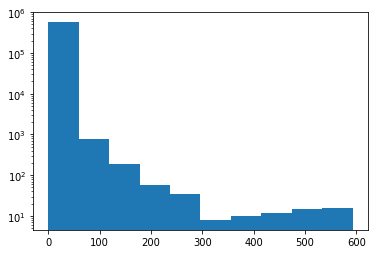

In [111]:
print('Helpfulness Denominator without outliers')
plt.hist(df_working.HelpfulnessDenominator, log = True);

Helpfulness Numerator without outliers


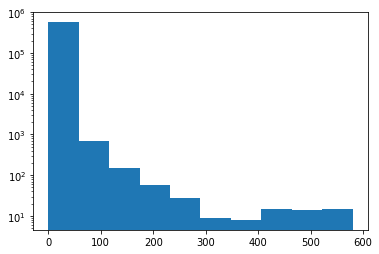

In [112]:
print('Helpfulness Numerator without outliers')
plt.hist(df_working.HelpfulnessNumerator, log = True);

In [113]:
# Reviews with no up/ down votes are not useful. I will only explore reviews that have 10 or more votes to
# "learn" from. Similarly drop neutral reviews (where Score = 3)
df_10 = df_working[(df_working.HelpfulnessDenominator > 10)]
df_10 = df_10[df_10['Score']!=3]
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19817 entries, 32 to 568324
Data columns (total 10 columns):
Id                        19817 non-null int64
ProductId                 19817 non-null object
UserId                    19817 non-null object
ProfileName               19817 non-null object
HelpfulnessNumerator      19817 non-null int64
HelpfulnessDenominator    19817 non-null int64
Score                     19817 non-null int64
Time                      19817 non-null int64
Summary                   19817 non-null object
Text                      19817 non-null object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [114]:
# The data set is significantly smaller
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19817 entries, 32 to 568324
Data columns (total 10 columns):
Id                        19817 non-null int64
ProductId                 19817 non-null object
UserId                    19817 non-null object
ProfileName               19817 non-null object
HelpfulnessNumerator      19817 non-null int64
HelpfulnessDenominator    19817 non-null int64
Score                     19817 non-null int64
Time                      19817 non-null int64
Summary                   19817 non-null object
Text                      19817 non-null object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


# Text clean up

### Make all characters in a string lower case

In [132]:
## Convert all characters to lowercase
df_10['Text'] = df_10['Text'].str.lower()
df_10['Summary'] = df_10['Summary'].str.lower()

### Tokenization

In [133]:
## Tokenize Summary column
import nltk
tokens_s = []
for elem in df_10.Summary:
    sentence = elem
    token = nltk.word_tokenize(sentence)
    tokens_s.append(token)

In [134]:
## Tokenize text column
tokens_t = []
for elem in df_10.Text:
    sentence = elem
    token = nltk.word_tokenize(sentence)
    tokens_t.append(token)

In [135]:
## Check to make sure there won't be any issues adding the tokens to the data frame
print(len(tokens_t))
print(len(tokens_s))

19817
19817


### Lemmatization

In [136]:
## Lemmanize
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/iris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [137]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

lemma_s = []
for elem in tokens_s:
    for word in elem:
        lemmatized = lmtzr.lemmatize(word)
        lemma_s.append(lemmatized)

In [138]:
lemma_t = []

for elem in tokens_t:
    for word in elem:
        lemmatized_t = lmtzr.lemmatize(word)
        lemma_t.append(lemmatized_t)

# Sentiment

In [139]:
# Assign class to reviews in order to later classify sentiment
X = df_10['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df_10['Score'].map(y_dict)

In [152]:
def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word:' : w, 'Impact Coefficient:' : coef})
        coeff_df = coeff_df.sort_values(['Impact Coefficient:', 'Word:'], ascending=[0, 1])
        print('')
        print('Top 15 positive terms')
        print(coeff_df.head(15).to_string(index=False))
        print('')
        print('Top 15 negative terms')        
        print(coeff_df.tail(15).to_string(index=False))

## Logistic Regression using Count Vec

In [153]:
c = CountVectorizer(stop_words = 'english')

text_fit(X, y, c, LogisticRegression())

# features: 35057
# train records: 14862
# test records: 4955
Model Accuracy: 0.8956609485368315

Top 15 positive terms
Word:  Impact Coefficient:
    amazing             1.982681
  delicious             1.979519
    awesome             1.951293
  excellent             1.933454
outstanding             1.896564
  fantastic             1.817464
       beat             1.767583
     highly             1.703538
     smooth             1.601180
       best             1.494907
     slight             1.482466
      yummy             1.445965
    perfect             1.445832
       eyes             1.439334
    biscoff             1.419535

Top 15 negative terms
Word:  Impact Coefficient:
         gross            -1.377102
         money            -1.383871
      returned            -1.406443
         bland            -1.408578
        refund            -1.491922
       changed            -1.557197
      crunchie            -1.675406
         shame            -1.717101
 unfortunately      

## Logistic Regression using ngrams

In [156]:
#different n-gram
tfidf_n2 = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
tfidf_n3 = TfidfVectorizer(ngram_range=(1,3),stop_words = 'english')

text_fit(X, y, tfidf_n2, LogisticRegression())

# features: 578895
# train records: 14862
# test records: 4955
Model Accuracy: 0.8839556004036327

Top 15 positive terms
Word:  Impact Coefficient:
    great             8.090148
     best             6.474701
     love             5.319236
delicious             5.221381
excellent             4.387633
      use             4.014012
   highly             3.481419
       ve             3.427392
     good             3.406608
  perfect             3.329552
   little             3.154747
    fresh             3.104994
     easy             3.001745
 favorite             2.996381
      day             2.968095

Top 15 negative terms
Word:  Impact Coefficient:
     received            -2.818296
          box            -2.829946
unfortunately            -2.850782
       return            -2.884334
   ingredient            -2.917677
        awful            -3.109953
  description            -3.130232
      thought            -3.185526
        worst            -3.245334
     terrible         

Model accuracy decreases in an n
-gram model using 3-word combinations.

## Class Imbalance

Can we do better by addressing the class imbalance?

To address the existing class impbalance, I will restrict the Helpfulness Numerator column to be more than 10.
I will try to instead only restrict the Denomincator. 

In [167]:
df_helpful = df_10[(df_10.HelpfulnessDenominator) > 10]

In [168]:
df_helpful['helpfullness_ratio'] = (df_10.HelpfulnessNumerator/df_10.HelpfulnessDenominator)

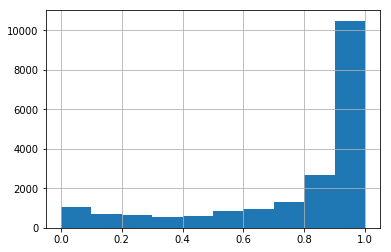

In [169]:
df_helpful.helpfullness_ratio.hist();

In [170]:
df_helpful.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,helpfullness_ratio
count,19817.000000,19817.000000,19817.000000,19817.000000,1.981700e+04,19817.000000
mean,287035.380936,19.801635,24.528183,3.440329,1.251298e+09,0.770491
std,161501.466299,32.256627,33.007436,1.813934,5.694551e+07,0.290739
min,33.000000,0.000000,11.000000,1.000000,9.482400e+08,0.000000
25%,152118.000000,10.000000,13.000000,1.000000,1.211674e+09,0.666667
50%,288514.000000,13.000000,16.000000,5.000000,1.259971e+09,0.909091
75%,427428.000000,20.000000,24.000000,5.000000,1.295482e+09,1.000000
max,568325.000000,580.000000,593.000000,5.000000,1.350605e+09,1.000000


In [171]:
helpfulness_array = (df_10.loc[:, 'HelpfulnessNumerator'] / df_10.loc[:, 'HelpfulnessDenominator'])

In [172]:
helpfulness_array.mean()

0.7704910269931855

In [173]:
df_helpful.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfullness_ratio
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,best of the instant oatmeals,mccann's instant oatmeal is great if you must ...,1.0


In [174]:
df_helpful.sort_values(by=['helpfullness_ratio'])

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfullness_ratio
58891,58892,B000ER1ER2,A18GKCC69KPR51,Norman Girard,0,26,2,1243036800,well,i really didn't notice elmo on the package? th...,0.0
386281,386282,B00073JVFU,A1CYNZMKTXO222,"Nylsa V. Barris ""Nukelegs""",0,12,1,1253664000,do not order this product....,it has been over three weeks and i still have ...,0.0
426976,426977,B0001PB98Q,A387KJ89FRUAUG,"smusprincess ""smusprincess""",0,19,1,1168473600,horrible seller,did not recieve on time and shipped to the wro...,0.0
31977,31978,B0062A87HA,A2NAGVAI22YXI9,B. Wyrick,0,11,4,1199664000,mistaken order,"i did order this item in the fall of 2007, but...",0.0
519024,519025,B000E7SYLG,A2XNJJ9TF70P4J,Angie,0,17,1,1299283200,disgusting,i don't know where these rave reviews are comi...,0.0
357812,357813,B001GCTTRQ,A1CYNZMKTXO222,"Nylsa V. Barris ""Nukelegs""",0,12,1,1253664000,do not order this product....,it has been over three weeks and i still have ...,0.0
386742,386743,B007OXJLZQ,A6TUCK8W9L8MJ,Fooled By Great Marketing,0,11,1,1297036800,wrong product,they sent me hazelnut and i ordered vanilla--i...,0.0
320900,320901,B0006ZN538,A2SH7OWE8QJYNC,Kaleidocherry,0,14,2,1339632000,not as happy as i wanted to be,for our inaugural attempt at baking with almon...,0.0
104292,104293,B0016512YG,A2APHQA8UQTV0,Marija,0,13,1,1217635200,my taste buds were overloaded after having jus...,with all the talk of snackwells being low in s...,0.0
266205,266206,B001D9RVMM,A3L5QAAH3J5AKY,Howard,0,11,2,1311292800,not tasty for my dog,these days it is not easy to find us made dog ...,0.0


In [175]:
# Look at 10717th value in sorted df_helpful to get the midpoint of helpfulness

df_helpful.sort_values(by=['helpfullness_ratio']).iloc[[10717]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfullness_ratio
381866,381867,B002133Z56,AOTCUEDTUD647,"Patrick F. James ""the chopper""",11,12,5,1265846400,great product,delicious with oatmeal in my 700 calorie break...,0.916667


In order to end up with balanced Helpful and Not_Helpful classes, I will try labeling half the data as each of the classes. The helpfulness ratio that partitions the data in half in .909091

In [176]:
df_helpful_working = df_helpful
df_helpful_working['Helpful'] = df_helpful.loc[:, 'Helpful'] = np.where(df_helpful.loc[:,'HelpfulnessNumerator'] /
                                       df_helpful.loc[:, 'HelpfulnessDenominator'] > 0.909, 1, 0)
df_helpful_working.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfullness_ratio,Helpful
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,best of the instant oatmeals,mccann's instant oatmeal is great if you must ...,1.000000,1
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,good instant,this is a good instant oatmeal from the best o...,1.000000,1
82,83,B003ZFRKGO,A2VOZX7YBT0D6D,"Johnnycakes ""Johnnycakes""",15,15,5,1325635200,forget molecular gastronomy - this stuff rocke...,i know the product title says molecular gastro...,1.000000,1
158,159,B000ITVLE2,A3NID9D9WMIV01,"Louie Arrighi ""Lou da Joo""",17,19,5,1260057600,tastes very fresh,"<span class=""tiny""> length:: 0:26 mins<br /><b...",0.894737,0
287,288,B001UJEN6C,A1XM65S80UQ2MD,Joseph Kagan,13,13,5,1276214400,great natural energy,"this is a fantastic product, and i wish it was...",1.000000,1


In [177]:
# The two classes are alot more balanced now

df_helpful_working['Helpful'].value_counts()

1    10236
0     9581
Name: Helpful, dtype: int64

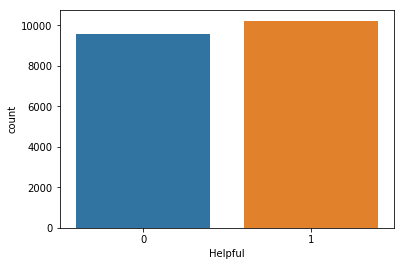

In [178]:
sns.countplot(x='Helpful', data = df_helpful_working);

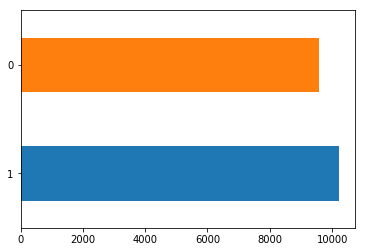

In [179]:
df_helpful_working.Helpful.value_counts().plot('barh');

Appending new lemmatized and tokenized text to the column 

In [180]:
# Store data to a new clean csv
df_helpful_working.to_csv("clean_labeled_data.csv")

## Bag of Words

In [181]:
## df_1 will be the data frame I use to make initial analysis on
df_1 = df_helpful_working

In [182]:
len(df_1.Text)
df_1['Text_Token'] = tokens_t
df_1['Summ_Token'] = tokens_s

In [183]:
df_1.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfullness_ratio,Helpful,Text_Token,Summ_Token
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,best of the instant oatmeals,mccann's instant oatmeal is great if you must ...,1.0,1,"[mccann, 's, instant, oatmeal, is, great, if, ...","[best, of, the, instant, oatmeals]"
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,good instant,this is a good instant oatmeal from the best o...,1.0,1,"[this, is, a, good, instant, oatmeal, from, th...","[good, instant]"


In [184]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

/Users/iris/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Investigations 
My original model will focus on the body of the review, not the title ('summary').

In [186]:
all_text_words = [word for tokens in df_1['Text_Token'] for word in tokens]
len_sentence = [len(tokens) for tokens in df_1['Text_Token']]
vocabulary = sorted(list(set(all_text_words)))

In [188]:
print('There are %s words total. The vocabulary is %s' % (len(all_text_words), len(vocabulary)))

There are 3526509 words total. The vocabulary is 49586


In [190]:
# Define new X train and test not to be confused with ones used earlier

def cv(df):
    count_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
    emb = count_vectorizer.fit_transform(df)
    return emb, count_vectorizer

list_text = df_1['Text_Token'].tolist()
list_label = df_1['Helpful'].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_text, list_label, test_size=0.2, 
                                                   random_state = 42)

In [191]:
X_train_counts, count_vectorizer = cv(X_train)
X_text_counts = count_vectorizer.transform(X_test)

In [192]:
X_text_counts

<3964x45051 sparse matrix of type '<class 'numpy.int64'>'
	with 369521 stored elements in Compressed Sparse Row format>

## Visualizing Classified Data Using the Helpfulness Denominator Ratio

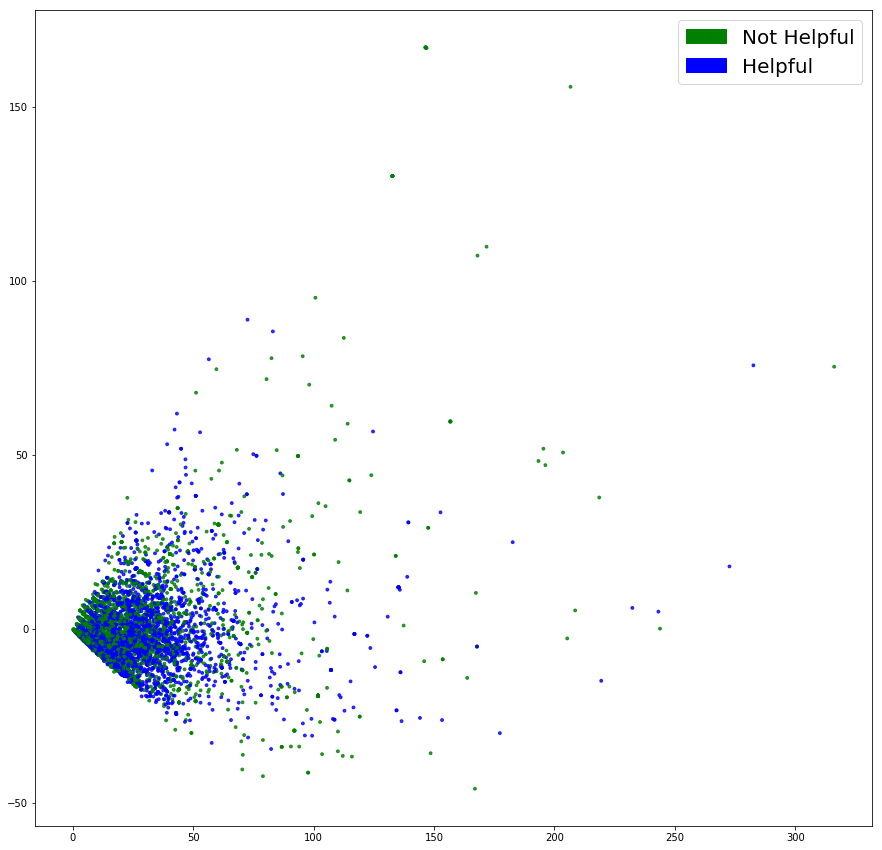

In [196]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['green','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='green', label='Not Helpful')
            green_patch = mpatches.Patch(color='blue', label='Helpful')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))          
plot_LSA(X_train_counts, y_train)
plt.show()

## Fitting a classifier 

In [197]:
X_train_counts, count_vectorizer = cv(X_train)
X_text_counts = count_vectorizer.transform(X_test)

In [198]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_text_counts)

In [199]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.787, precision = 0.788, recall = 0.787, f1 = 0.787


## Confusion Matrix

In [202]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('Actual Category', fontsize=20)
    plt.xlabel('Predicted Category', fontsize=20)

    return plt

In [204]:
confusion_matrix(y_test, y_predicted_counts)

array([[1534,  384],
       [ 461, 1585]])

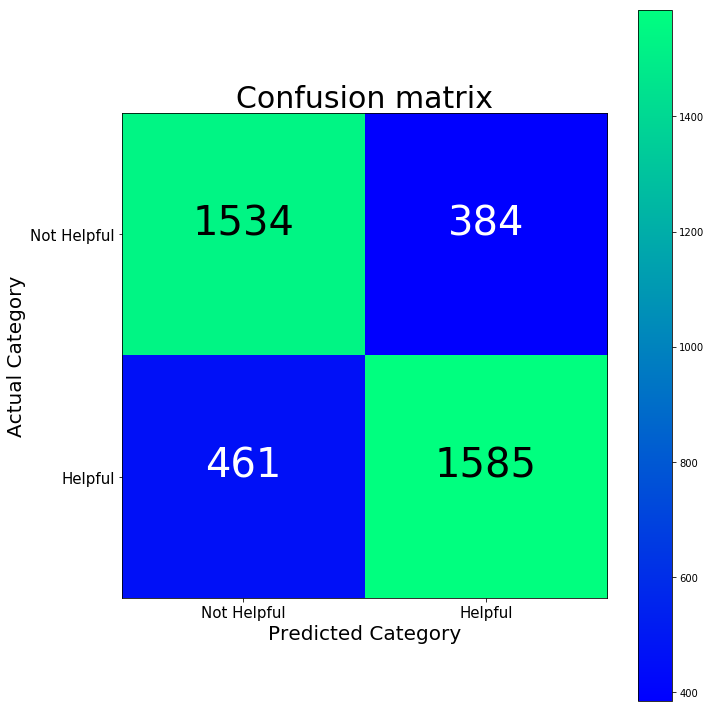

In [205]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Helpful','Helpful'], normalize=False, title='Confusion matrix')


plt.show()

## LDA and NMF

In [206]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [207]:
# Dispaling the top topical words the models

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [208]:
no_features = 1000

count_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
emb = count_vectorizer.fit_transform(df)

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english',tokenizer=lambda doc: doc, lowercase=False)
tfidf = tfidf_vectorizer.fit_transform(list_text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english',tokenizer=lambda doc: doc, lowercase=False)
tf = tf_vectorizer.fit_transform(list_text)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 2

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/Users/iris/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
< > / br , : ) '' ( ``
Topic 1:
, ! 's n't like food ) ( coffee product
Topic 0:
> < / br , ) ( food 's :
Topic 1:
, ! n't 's like ) ( product just coffee


The three cells below can be used to create NMF and LDA models for different number of topics and number of top words.

In [209]:
no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/Users/iris/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
< > / br : , ) '' ( -
Topic 1:
, 's food n't ) ( like product `` ''
Topic 2:
coffee cup , keurig k-cups k-cup bold roast blend 's
Topic 3:
! $ ... ? great amazon product buy n't love
Topic 4:
tea green teas , drink like taste bags drinking flavor
Topic 0:
> < / br , ) ( : '' ``
Topic 1:
, ! coffee 's $ n't amazon box price like
Topic 2:
, like 's ! n't taste ) ( just flavor
Topic 3:
, product `` '' ( ) oil ! salt n't
Topic 4:
, food 's n't dog day cat tea just dogs


In [210]:
no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/Users/iris/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
< > / br : , ) ( - ?
Topic 1:
, 's ) ( day n't little just ingredients 've
Topic 2:
coffee cup keurig k-cups k-cup bold roast blend strong coffees
Topic 3:
! ... great ? love ordered just order delicious right
Topic 4:
tea green teas drink bags like drinking taste leaf black
Topic 5:
food dog cat dogs cats vet 's foods diet ingredients
Topic 6:
$ amazon product price ? buy box shipping order bag
Topic 7:
like n't taste 's chocolate ... flavor good just great
Topic 8:
'' `` salt ( ) : organic product href= /a
Topic 9:
oil coconut olive use hair skin oils organic cooking water
Topic 0:
, food 's cat n't eating cats eat diet day
Topic 1:
! , $ bag price buy amazon n't 's box
Topic 2:
, '' `` sugar ( ) 's organic product n't
Topic 3:
, product oil amazon order company products received ordered quality
Topic 4:
, tea ! drink 's green n't day like honey
Topic 5:
, ... n't ! 's dog like did just dogs
Topic 6:
, coffee cup 's like blend taste keurig flavor n't
Topic 7:
, like taste 's

In [211]:
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/Users/iris/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


KeyboardInterrupt: 

# pyLDAvis

I wanted to add some visulazitaion to my model and turned to pyLDAvis, a Python library for interactive topic model visualization. It is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data.

### Convert to document-term matrix

In [212]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df_working.Text)
print(dtm_tf.shape)

(568408, 27696)


In [213]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_working.Text)
print(dtm_tfidf.shape)

(568408, 27696)


### Fit Latent Dirichlet Allocation models

It would take too long to run the code on the entire data set locally, so I created a subset for LDA and Visualizations. However, the code for all of the data is in the appendix.

In [216]:
subbiesub = dtm_tf[:15000]
print(subbiesub.shape)

(15000, 27696)


In [218]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/iris/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/iris/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.287252  0.008296       1        1  44.348459
9      0.258843 -0.053561       2        1  22.439171
3      0.143434  0.128429       3        1   7.221231
8      0.143282 -0.020240       4        1   6.993679
4     -0.034091 -0.241101       5        1   4.349269
5     -0.101068  0.236203       6        1   3.938845
0     -0.137048  0.131366       7        1   3.576908
6     -0.199630 -0.013106       8        1   2.596081
2     -0.143919 -0.154011       9        1   2.508942
1     -0.217056 -0.022274      10        1   2.027416, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
18925  Default  154533.000000      product  154533.000000  30.0000  30.0000
776    Default   96008.000000       amazon   96008.000000  29.0000  29.0000
4604   Default  207576.000000       coffee  207576.000000  28.0000  28.0000
9473   Default  100195.000000         food  100195.000000  27.0000  27.0000
26794  Default   49049.000000        water   49049.000000  26.0000  26.0000
7448   Default   46472.000000        drink   46472.000000  25.0000  25.0000
7209   Default   77920.000000          dog   77920.000000  24.0000  24.0000
10678  Default  159978.000000        great  159978.000000  23.0000  23.0000
2700   Default   43803.000000          box   43803.000000  22.0000  22.0000
25326  Default   65747.000000       treats   65747.000000  21.0000  21.0000
15424  Default   44723.000000          mix   44723.000000  20.0000  20.0000
17181  Default   36543.000000         pack   36543.000000  19.0000  19.0000
5288   Default   35179.000000      cookies   35179.000000  18.0000  18.0000
23810  Default   53441.000000        sugar   53441.000000  17.0000  17.0000
14510  Default   72339.000000         make   72339.000000  16.0000  16.0000
21042  Default   27317.000000         salt   27317.000000  15.0000  15.0000
4141   Default   38387.000000        chips   38387.000000  14.0000  14.0000
13086  Default   25490.000000        juice   25490.000000  13.0000  13.0000
4179   Default   56591.000000    chocolate   56591.000000  12.0000  12.0000
16832  Default   43227.000000        order   43227.000000  11.0000  11.0000
14259  Default  117785.000000         love  117785.000000  10.0000  10.0000
9691   Default   49402.000000         free   49402.000000   9.0000   9.0000
26142  Default   79455.000000          use   79455.000000   8.0000   8.0000
16853  Default   42234.000000      organic   42234.000000   7.0000   7.0000
15249  Default   36459.000000         milk   36459.000000   6.0000   6.0000
16655  Default   22774.000000          oil   22774.000000   5.0000   5.0000
4725   Default   19883.000000          com   19883.000000   4.0000   4.0000
24387  Default  164684.000000        taste  164684.000000   3.0000   3.0000
10362  Default   27701.000000       gluten   27701.000000   2.0000   2.0000
22484  Default   27608.000000        snack   27608.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
13342  Topic10    2372.254623          kit    2404.269708   3.8850  -5.1383
10991  Topic10    2119.336312         hair    2151.355188   3.8834  -5.2510
17430  Topic10    2075.978421         pass    2107.995992   3.8831  -5.2717
26323  Topic10    1986.020971       vendor    2018.038053   3.8824  -5.3160
15165  Topic10    1964.099655          mic    1996.111474   3.8822  -5.3271
27072  Topic10    1947.802186    wholesome    1979.822914   3.8821  -5.3354
11965  Topic10    1909.094062       icicle    1941.106217   3.8818  -5.3555
7044   Topic10    1858.712408   disposable    1890.760771   3.8813  -5.3822
9972   Topic10    1777.166162         gain    1809.193973   3.8805  -5.4271
5489   Topic10    1760.862383          cow    1792.881793   3.8804  -5.4363
22092  Topic10    1742.452195      simila

In [219]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/iris/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/iris/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.287252  0.008296       1        1  44.348459
9      0.258843 -0.053561       2        1  22.439171
3      0.143434  0.128429       3        1   7.221231
8      0.143282 -0.020240       4        1   6.993679
4     -0.034091 -0.241101       5        1   4.349269
5     -0.101068  0.236203       6        1   3.938845
0     -0.137048  0.131366       7        1   3.576908
6     -0.199630 -0.013106       8        1   2.596081
2     -0.143919 -0.154011       9        1   2.508942
1     -0.217056 -0.022274      10        1   2.027416, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
18925  Default  154533.000000      product  154533.000000  30.0000  30.0000
776    Default   96008.000000       amazon   96008.000000  29.0000  29.0000
4604   Default  207576.000000       coffee  207576.000000  28.0000  28.0000
9473   Default  100195.000000         food  100195.000000  27.0000  27.0000
26794  Default   49049.000000        water   49049.000000  26.0000  26.0000
7448   Default   46472.000000        drink   46472.000000  25.0000  25.0000
7209   Default   77920.000000          dog   77920.000000  24.0000  24.0000
10678  Default  159978.000000        great  159978.000000  23.0000  23.0000
2700   Default   43803.000000          box   43803.000000  22.0000  22.0000
25326  Default   65747.000000       treats   65747.000000  21.0000  21.0000
15424  Default   44723.000000          mix   44723.000000  20.0000  20.0000
17181  Default   36543.000000         pack   36543.000000  19.0000  19.0000
5288   Default   35179.000000      cookies   35179.000000  18.0000  18.0000
23810  Default   53441.000000        sugar   53441.000000  17.0000  17.0000
14510  Default   72339.000000         make   72339.000000  16.0000  16.0000
21042  Default   27317.000000         salt   27317.000000  15.0000  15.0000
4141   Default   38387.000000        chips   38387.000000  14.0000  14.0000
13086  Default   25490.000000        juice   25490.000000  13.0000  13.0000
4179   Default   56591.000000    chocolate   56591.000000  12.0000  12.0000
16832  Default   43227.000000        order   43227.000000  11.0000  11.0000
14259  Default  117785.000000         love  117785.000000  10.0000  10.0000
9691   Default   49402.000000         free   49402.000000   9.0000   9.0000
26142  Default   79455.000000          use   79455.000000   8.0000   8.0000
16853  Default   42234.000000      organic   42234.000000   7.0000   7.0000
15249  Default   36459.000000         milk   36459.000000   6.0000   6.0000
16655  Default   22774.000000          oil   22774.000000   5.0000   5.0000
4725   Default   19883.000000          com   19883.000000   4.0000   4.0000
24387  Default  164684.000000        taste  164684.000000   3.0000   3.0000
10362  Default   27701.000000       gluten   27701.000000   2.0000   2.0000
22484  Default   27608.000000        snack   27608.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
13342  Topic10    2372.254623          kit    2404.269708   3.8850  -5.1383
10991  Topic10    2119.336312         hair    2151.355188   3.8834  -5.2510
17430  Topic10    2075.978421         pass    2107.995992   3.8831  -5.2717
26323  Topic10    1986.020971       vendor    2018.038053   3.8824  -5.3160
15165  Topic10    1964.099655          mic    1996.111474   3.8822  -5.3271
27072  Topic10    1947.802186    wholesome    1979.822914   3.8821  -5.3354
11965  Topic10    1909.094062       icicle    1941.106217   3.8818  -5.3555
7044   Topic10    1858.712408   disposable    1890.760771   3.8813  -5.3822
9972   Topic10    1777.166162         gain    1809.193973   3.8805  -5.4271
5489   Topic10    1760.862383          cow    1792.881793   3.8804  -5.4363
22092  Topic10    1742.452195      simila

# Appendix 

Below is the code for performing LDA on all of the reviews. 

In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)